## **Import libraries**
some of the libraries need to be install befor importing to the notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import random
import cv2
import sys
import json
import datetime

import torch
import torch.nn as nn
import torchvision
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import skimage.draw
from PIL import Image, ImageDraw, ImageOps
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw

import IPython
import requests
from io import BytesIO
import base64
from math import trunc


### **Clone the git repository**

- if you need see the repository first [click here](https://github.com/pytorch/vision) for more information





In [2]:
# if you have problem with clone the git repository and copy them the content folder
# uncomment code below and clone the reposirtory again

# !rm -r /content/vision *.py

!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

Cloning into 'vision'...
remote: Enumerating objects: 355980, done.
remote: Counting objects: 100% (6220/6220), done.
remote: Compressing objects: 100% (448/448), done.
remote: Total 355980 (delta 5771), reused 6143 (delta 5744), pack-reused 349760
Receiving objects: 100% (355980/355980), 710.11 MiB | 16.33 MiB/s, done.
Resolving deltas: 100% (328297/328297), done.
/content/vision
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at be376084d8 version check against PyTorch's CUDA version

In [3]:
!cp references/detection/engine.py ../
!cp references/detection/transforms.py ../
!cp references/detection/utils.py ../
!cp references/detection/coco_utils.py ../
!cp references/detection/coco_eval.py ../
%cd /content/

/content


### **Roboflow datasets**
- if need datasets  to train you instance segmentation fine tuning create the acount in [Roboflow](https://roboflow.com/)
- now first pip install roboflow and import depndencies
- It's important to learn how work with the datasets in roboflow

    1. first search for desire datasets
    2. click on download datasets and select desire format then select show download code
    3. finally the code will appear on the screen you have to copy the last 3 lines and type your `API key` in the ```Roboflow()``` function as input

<img src="https://2486075003-files.gitbook.io/~/files/v0/b/gitbook-x-prod.appspot.com/o/spaces%2F-M6S9nPJhEX9FYH6clfW%2Fuploads%2F1aSnS69iqGLUiFIHeUFD%2FScreenshot%202023-07-05%20at%2011.39.44.png?alt=media&token=4927d505-878e-499d-8d41-442f8db7e5f6" width="500">
<img src="https://miro.medium.com/v2/resize:fit:1020/1*mGVY02xUFvPBwL_pDI-U-A.png" width="350">


In [ ]:
!pip install roboflow
from roboflow import Roboflow

In [8]:

# if you have problem with import the roboflow dataset
# uncomment the below line and run the cell again
# !rm -r /content/Insulators-and-Connectors-Segmentation-3

api_key = "Your personal API key from roboflow"
rf = Roboflow(api_key=api_key)
project = rf.workspace("matisse-jrshb").project("insulators-and-connectors-segmentation")
dataset = project.version(3).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Insulators-and-Connectors-Segmentation-3 in coco:: 100%|██████████| 296/296 [00:00<00:00, 1021.84it/s]


#### **Modify the datasets**
if you export coco datasets you will have the json files in each treain/val/test so you need to move it to root directory of roboflow datasets to loop throw images and make them ready for the model features and lables

In [9]:
%cd /content/Insulators-and-Connectors-Segmentation-3
!mv train/_annotations.coco.json train.json
!mv test/_annotations.coco.json test.json
!mv valid/_annotations.coco.json valid.json
%cd /content

/content/Insulators-and-Connectors-Segmentation-3
/content


#### **Modify json file for coco**
if you need make any change to your json file use the peace of code in below cell and modify the json file
- **Note**: you have to save the modify file to new_file.json don't try to overwrite the orginal jason file

In [10]:
# os.chdir('/content/Insulators-and-Connectors-Segmentation-3')
# for dir_name in next(os.walk('.'))[1]:
#     annotation_path = f"/content/Insulators-and-Connectors-Segmentation-3/{dir_name}.json"
#     json_file = open(annotation_path)
#     coco = json.load(json_file)
#     json_file.close()
#     for i, name in enumerate(os.listdir(dir_name)):
#         new_name = f"{i + 1}.jpg"
#         coco['images'][i]['file_name'] = new_name

#         file_name = os.path.join(os.getcwd(), dir_name, name)
#         new_name = os.path.join(os.getcwd(), dir_name, new_name)
#         os.rename(file_name, new_name)
#     out_file = open(f"{dir_name}2.json", "w")
#     json.dump(coco, out_file)
#     out_file.close()

# %cd /content

## **Preprocess the datasets**
if you have images and json files for coco dataset you need to export every images segmentation and masks for pytorch model

```
annotation_path = "path to json file"
image_dir = 'path to images directory'
coco_dataset = CocoDataset(annotation_path, image_dir)
out = coco_dataset.display_image(image_id='random', show_polys=False,
                      show_mask=False, show_bbox=False, show_crowds=False)
```
```
                display_image hyper parameter
image_id='random' -->   if need specific image mention image_id in json file
                            if you have many images with json file loop throw them all
                            and then save them in folder for train/val/test
                            save masks in numpy format for better exprience
show_polys=True -->     show image with annotation
show_mask=True -->      show mask in grayscale
show_bbox=True -->      show images with segments and bboxes
show_crowds=True
yolo_txt=True -->       save txt file in "/content/dataset/labels"
```

In [11]:
class CocoDataset():
    def __init__(self, annotation_path, image_dir):
        self.annotation_path = annotation_path
        self.image_dir = image_dir
        self.colors = [(100, 100, 200), (255, 0, 255), (255, 255, 0),
                       (255, 100, 100), (0, 255, 255), (255, 0, 0),
                        (0, 255, 0), (0, 0, 255), (180, 100, 120)]

        json_file = open(self.annotation_path)
        self.coco = json.load(json_file)
        json_file.close()

        self.process_info()
        self.process_images()
        self.process_segmentations()


    def display_info(self):
        print('Dataset Info:')
        print('=============')
        for key, item in self.info.items():
            print('  {}: {}'.format(key, item))

    def display_image(self, image_id='random', show_polys=True,
                      show_mask=True, show_bbox=True, show_crowds=True):
        print('Image:')
        print('======')
        if image_id == 'random':
            image_id = random.choice(list(self.images.keys()))

        # Print the image info
        image_info = self.images[image_id]
        for key, val in image_info.items():
            print(f'  {key}: {val}')

        image_path = os.path.join(self.image_dir, image_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Calculate the size and adjusted display size
        max_width = 600
        image_width, image_height = image.shape[0], image.shape[1]
        # adjusted_width = min(image_width, max_width)
        # adjusted_ratio = adjusted_width / image_width
        # adjusted_height = int(adjusted_ratio * image_height)
        adjusted_width = 224
        adjusted_ratio = 1
        adjusted_height = int(adjusted_ratio * adjusted_width)


        # Create list of polygons to be drawn
        polygons = {}
        bbox_polygons = {}
        rle_regions = {}
        poly_colors = {}
        for i, segm in enumerate(self.segmentations[image_id]):
            polygons_list = []

            # Add the polygon segmentation
            for segmentation_points in segm['segmentation']:
                polygons_list.append(np.array(segmentation_points).astype(int))

            polygons[segm['id']] = polygons_list

            # extract bbox as int for use in opencv
            bbox = [int(x) for x in segm['bbox']]
            bbox[2], bbox[3] = bbox[0] + bbox[2], bbox[1] + bbox[3]
            bbox_polygons[segm['id']] = bbox

            # extract point for use in opencv
            points= []
            for seg_id, points_list in polygons.items():

                pnts = []
                idx = []
                for item in points_list:
                    idx.append(len(item))
                    i = 0
                    while i < (len(item) - 1):
                        pnts.append(item[i:i+2].tolist())
                        i += 2
                    points.append(pnts)

            # segment the orginal image
            overlay = image.copy()
            for i in range(len(polygons)):
                pts = np.array(points[i]).reshape((-1, 1, 2))
                cv2.fillPoly(overlay, [pts], self.colors[i])

            alpha = 0.4
            segmented_image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)
            segmented_image_resize = cv2.resize(segmented_image, (adjusted_width, adjusted_height))

            # extract the mask of segmented images
            mask = np.zeros((image_width, image_height ), dtype=np.uint8)
            for i in range(len(polygons)):
                pts = np.array(points[i]).reshape((-1, 1, 2))
                cv2.fillPoly(mask, [pts], (i+1,0, 0))

            mask = cv2.resize(mask, (adjusted_width, adjusted_height))

        for i, (seg_id, points) in enumerate(bbox_polygons.items()):
            pnt1 = (points[0], points[1])
            pnt2 = points[2], points[3]
            img_with_bbox = cv2.rectangle(segmented_image, pnt1, pnt2, self.colors[i], 3)
        img_with_bbox = cv2.resize(img_with_bbox, (adjusted_width, adjusted_height))

        if show_polys:
            plt.imshow(segmented_image_resize)
            plt.show()

        if show_mask:
            plt.imshow(mask, 'gray')
            plt.show()

        if show_bbox:
            plt.imshow(img_with_bbox)
            plt.show()

        image = cv2.resize(image, (adjusted_width, adjusted_height))
        return image, segmented_image_resize, mask, img_with_bbox, image_info['file_name']



    def process_info(self):
        self.info = self.coco['info']

    def process_images(self):
        self.images = {}
        for image in self.coco['images']:
            image_id = image['id']
            if image_id in self.images:
                print(f"ERROR: Skipping duplicate image id: {image}")
            else:
                self.images[image_id] = image

    def process_segmentations(self):
        self.segmentations = {}
        for segmentation in self.coco['annotations']:
            image_id = segmentation['image_id']
            if image_id not in self.segmentations:
                self.segmentations[image_id] = []
            self.segmentations[image_id].append(segmentation)

In [12]:
# annotation_path = '/content/labels_my_COCO.json'
# image_dir = '/content/pin insulator'
# annotation_path = '/content/Insulators-and-Connectors-Segmentation-3/test.json'
# image_dir = '/content/Insulators-and-Connectors-Segmentation-3/test'
# coco_dataset = CocoDataset(annotation_path, image_dir)
# a = coco_dataset.display_image(11)

### **Create directory**
we need to creat directory and save
```
|--datasets
    |--train
        |--images
        |--masks
        |--segmented
        |--segmented_with_bbox
    |--test
        |--images
        |--masks
        |--segmented
        |--segmented_with_bbox
    |--val
        |--images
        |--masks
        |--segmented
        |--segmented_with_bbox
```

In [13]:
# %cd /content
# !rm -r dataset
!mkdir dataset
!mkdir -p dataset/train/images
!mkdir -p dataset/train/masks
!mkdir -p dataset/train/segmented_with_bbox
!mkdir -p dataset/train/segmented

!mkdir -p dataset/test/images
!mkdir -p dataset/test/masks
!mkdir -p dataset/test/segmented_with_bbox
!mkdir -p dataset/test/segmented

!mkdir -p dataset/val/images
!mkdir -p dataset/val/masks
!mkdir -p dataset/val/segmented_with_bbox
!mkdir -p dataset/val/segmented
# !pwd

### **Roboflow Dataset**
roboflow export datasets as train/val/test sets
so we have to loop throw every folder separatly

In [ ]:
import fnmatch

# annotation_path = '/content/labels_my_COCO.json'
# image_dir = '/content/pin insulator'

annotation_path = '/content/Insulators-and-Connectors-Segmentation-3/train.json'
image_dir = '/content/Insulators-and-Connectors-Segmentation-3/train'
coco_dataset = CocoDataset(annotation_path, image_dir)
# coco_dataset.display_info()

count = len(fnmatch.filter(os.listdir(image_dir), '*.*'))
for i in range(count):
    try:
        a = coco_dataset.display_image(i+1, show_polys=False,
                      show_mask=False, show_bbox=False, show_crowds=False)
        np.save(f'/content/dataset/train/images/{a[4]}', a[0], allow_pickle=True)
        np.save(f'/content/dataset/train/segmented/{a[4]}', a[1], allow_pickle=True)
        np.save(f'/content/dataset/train/masks/{a[4]}', a[2], allow_pickle=True)
        np.save(f'/content/dataset/train/segmented_with_bbox/{a[4]}', a[3], allow_pickle=True)
    except: "exception"

In [ ]:
annotation_path = '/content/Insulators-and-Connectors-Segmentation-3/valid.json'
image_dir = '/content/Insulators-and-Connectors-Segmentation-3/valid'
coco_dataset = CocoDataset(annotation_path, image_dir)
# coco_dataset.display_info()
count = len(fnmatch.filter(os.listdir(image_dir), '*.*'))

for i in range(41):
    try:
        a = coco_dataset.display_image(i+1, show_polys=False,
                      show_mask=False, show_bbox=False, show_crowds=False)
        np.save(f'/content/dataset/val/images/{a[4]}', a[0], allow_pickle=True)
        np.save(f'/content/dataset/val/segmented/{a[4]}', a[1], allow_pickle=True)
        np.save(f'/content/dataset/val/masks/{a[4]}', a[2], allow_pickle=True)
        np.save(f'/content/dataset/val/segmented_with_bbox/{a[4]}', a[3], allow_pickle=True)
    except: "exception"


In [ ]:
annotation_path = '/content/Insulators-and-Connectors-Segmentation-3/test.json'
image_dir = '/content/Insulators-and-Connectors-Segmentation-3/test'
coco_dataset = CocoDataset(annotation_path, image_dir)
# coco_dataset.display_info()

count = len(fnmatch.filter(os.listdir(image_dir), '*.*'))

for i in range(28):
    try:
        a = coco_dataset.display_image(i+1, show_polys=False,
                        show_mask=False, show_bbox=False, show_crowds=False)
        np.save(f'/content/dataset/test/images/{a[4]}', a[0], allow_pickle=True)
        np.save(f'/content/dataset/test/segmented/{a[4]}', a[1], allow_pickle=True)
        np.save(f'/content/dataset/test/masks/{a[4]}', a[2], allow_pickle=True)
        np.save(f'/content/dataset/test/segmented_with_bbox/{a[4]}', a[3], allow_pickle=True)
    except: "exception"

### **Costum dataset**
uplade you zip file and then unzip them with cells below
- **Note**: figure out your self that how many of the data you need in train/val/test sets and mention the path

In [ ]:
!unzip /content/pin_insulator.zip

In [ ]:
!unzip /content/pin_insulator2.zip

In [ ]:
annotation_path = '/content/labels_my_COCO.json'
image_dir = '/content/pin insulator'
coco_dataset = CocoDataset(annotation_path, image_dir)
# coco_dataset.display_info()
count = len(fnmatch.filter(os.listdir(image_dir), '*.*'))

for i in range(count - 1):
    a = coco_dataset.display_image(i+1, show_polys=False,
                        show_mask=False, show_bbox=False, show_crowds=False)
    np.save(f'/content/dataset/train/images/a{a[4]}', a[0], allow_pickle=True)
    np.save(f'/content/dataset/train/segmented/a{a[4]}', a[1], allow_pickle=True)
    np.save(f'/content/dataset/train/masks/a{a[4]}', a[2], allow_pickle=True)
    np.save(f'/content/dataset/train/segmented_with_bbox/a{a[4]}', a[3], allow_pickle=True)

In [ ]:
annotation_path = '/content/labels_my_COCO2.json'
image_dir = '/content/pin insulator2'
coco_dataset = CocoDataset(annotation_path, image_dir)
# coco_dataset.display_info()
count = len(fnmatch.filter(os.listdir(image_dir), '*.*'))

for i in range(count):
    a = coco_dataset.display_image(i+1, show_polys=False,
                        show_mask=False, show_bbox=False, show_crowds=False)
    np.save(f'/content/dataset/train/images/a{a[4]}', a[0], allow_pickle=True)
    np.save(f'/content/dataset/train/segmented/a{a[4]}', a[1], allow_pickle=True)
    np.save(f'/content/dataset/train/masks/a{a[4]}', a[2], allow_pickle=True)
    np.save(f'/content/dataset/train/segmented_with_bbox/a{a[4]}', a[3], allow_pickle=True)

In [23]:
# !zip -r /content/dataset_np.zip /content/dataset

### **Get data ready for pytorch input**
now you need the mention the path of images and masks directories

In [24]:
import torchvision.transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    transforms.append(T.transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)))
    transforms.append(T.Resize((224, 224)))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path, transforms):
        self.root = path
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(path, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(path, "masks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = np.load(img_path)
        img = Image.fromarray(img).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = np.load(mask_path)

        # convert the PIL Image into a numpy array
        # mask = np.array(mask)

        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None])

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)


        if self.transforms is not None:

            img = self.transforms(img)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target

    def __len__(self):
        return len(self.imgs)

## **Creat model for fine tuning**
if you have `import torch._six` error open `coco_eval.py` and comment out the import line

In [25]:
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 315MB/s]


In [26]:
# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 69.4MB/s]


In [27]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, weights="COCO_V1")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [28]:
from engine import train_one_epoch, evaluate
import utils

In [29]:
# use our dataset and defined transformations
dataset = CustomDataset('/content/dataset/train', get_transform(train=True))
dataset_test = CustomDataset('/content/dataset/test', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

In [30]:
device = 'cuda' if torch.cuda.is_available() else torch.device('cpu')
device

'cuda'

In [33]:
# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.006,
                            momentum=0.85, weight_decay=0.00055)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [34]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)


        targets["boxes"] = targets["boxes"].reshape(-1, 4).to(device)
        targets["labels"] = targets["labels"].reshape(-1,).to(device)
        targets["masks"] = targets["masks"].reshape(-1, 224, 224).to(device)
        targets["image_id"] = targets["image_id"].reshape(-1,).to(device)
        targets["area"] = targets["area"].reshape(-1,).to(device)
        targets["iscrowd"] = targets["iscrowd"].reshape(-1,).to(device)
        targets = [targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [35]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


Epoch: [0]  [  0/246]  eta: 0:30:35  lr: 0.000030  loss: 2.4835 (2.4835)  loss_classifier: 1.1934 (1.1934)  loss_box_reg: 0.0028 (0.0028)  loss_mask: 0.7607 (0.7607)  loss_objectness: 0.4940 (0.4940)  loss_rpn_box_reg: 0.0326 (0.0326)  time: 7.4616  data: 0.0455  max mem: 961
Epoch: [0]  [ 10/246]  eta: 0:03:23  lr: 0.000275  loss: 2.2549 (2.1083)  loss_classifier: 0.6540 (0.6703)  loss_box_reg: 0.0458 (0.0429)  loss_mask: 1.1942 (1.0968)  loss_objectness: 0.2065 (0.2706)  loss_rpn_box_reg: 0.0230 (0.0277)  time: 0.8608  data: 0.0117  max mem: 1130
Epoch: [0]  [ 20/246]  eta: 0:02:01  lr: 0.000520  loss: 1.1371 (1.5303)  loss_classifier: 0.1039 (0.3847)  loss_box_reg: 0.0438 (0.0416)  loss_mask: 0.8052 (0.9033)  loss_objectness: 0.1060 (0.1817)  loss_rpn_box_reg: 0.0108 (0.0190)  time: 0.1936  data: 0.0068  max mem: 1131
Epoch: [0]  [ 30/246]  eta: 0:01:32  lr: 0.000764  loss: 0.8100 (1.2985)  loss_classifier: 0.1035 (0.3017)  loss_box_reg: 0.0631 (0.0571)  loss_mask: 0.5820 (0.7867)  

## **Get prediction**

In [123]:
def get_prediction(model, image_path=None, test_datast=None):
    if image_path:
        image = plt.imread(image_path)
        img = Image.fromarray(image).convert("RGB")
        transform = get_transform(train=False)
        img = transform(img)
        image = cv2.resize(image, (224, 224))

    if test_datast:
        # mention test path to choose random image from testdataset
        image_dir = '/content/Insulators-and-Connectors-Segmentation-3/test'
        count = len(fnmatch.filter(os.listdir(image_dir), '*.*'))
        num = np.random.randint(0, count - 1)
        img, _ = dataset_test[num]
        image = img.mul(255).permute(1, 2, 0).byte().numpy()

    model = model.to(device)
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

    pred_mask = (prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy() > 90).astype(np.uint8)

    # export the mask contour for plot segmented image
    contours, _ = cv2.findContours(pred_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # Draw exported contour on orginal image and save it is new image
    overlay = image.copy()
    cv2.drawContours(overlay,contours,-1,(255,0,0), -1)
    alpha = 0.4
    segmented_image = cv2.addWeighted(overlay, alpha, image, 1 - alpha, 0)

    # Draw bbox with exported conour around the predicted object
    cnt = contours[0]
    x, y, w, h = cv2.boundingRect(cnt)
    img = cv2.rectangle(segmented_image, (x,y), (x+w,y+h), (255,0,0), 2)

    fig = plt.figure(figsize=(12, 12))
    images = [image, segmented_image, pred_mask]
    title = ['Orginal image', 'Segmented image', 'Predicted mask']


    for i, item in enumerate(images):
        fig.add_subplot(1, 3, i + 1)
        plt.imshow(item, 'gray')
        plt.title(title[i])
    plt.show()

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).


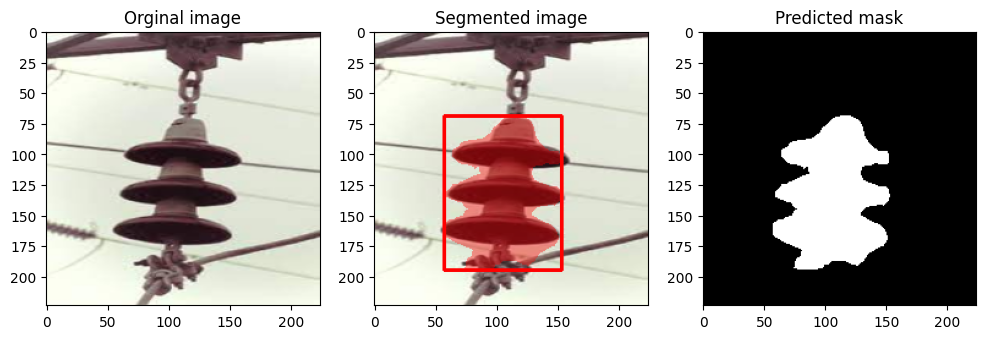

In [120]:
image_path = "/content/insulator_test2.jpg"
get_prediction(model=model, image_path=image_path)

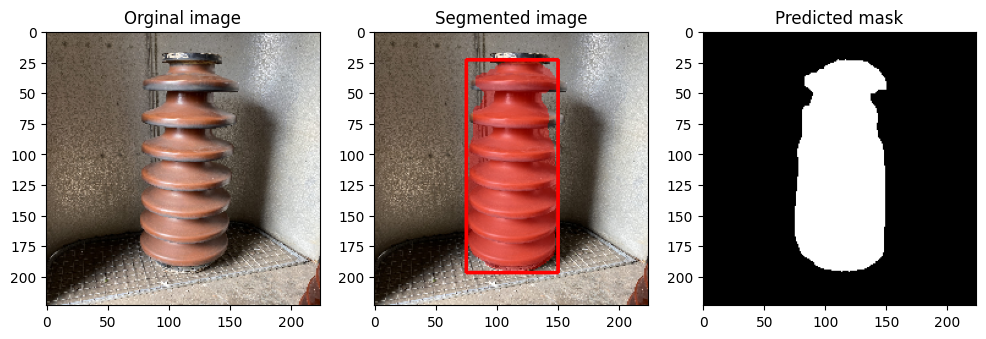

In [121]:
image_path = "/content/insulator_test.jpg"
get_prediction(model=model, image_path=image_path)

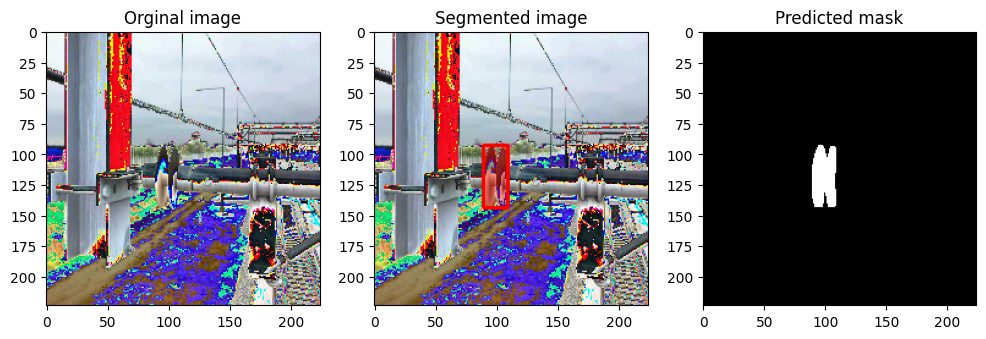

In [138]:
get_prediction(model=model, test_datast=dataset_test)

In [40]:
PATH = "/content/model_state_dict.pt"
torch.save(model.state_dict(), PATH)

In [41]:
PATH = "/content/model.pt"
torch.save(model, PATH)

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
